In [2737]:
import json
import os

file_name = 'outlier-comment'
parent_path = '/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/reply-tree/comment-section'
file = f'{file_name}.json'

with open(os.path.join(parent_path, file)) as f:
   comment_json = json.load(f)

In [2738]:
all_comments = []

def replyTree(node):
    global all_comments
    dict = {}
    dict['comment'] = node['content']
    dict['time'] = node['createdAt']
    # dict['username'] = node['username']
    dict['id'] = node['id']
    all_comments.append(dict)
    
    if len(node['replies']) == 0:
        return
    for ch in node['replies']:
        replyTree(ch)

In [2739]:

for i, json in enumerate(comment_json):
    replyTree(json)

In [2740]:
import pandas as pd
df = pd.DataFrame(all_comments)
# df.to_csv("/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/reply-tree/csv/fox-defund-chinese-communist-05-12-2023_16:15:52.csv")

In [2741]:
df.head(10)

,comment,time,id
0,I hate you Zad68 unblock me you stupid motherf...,"22 Dec, 2023 11:28 AM",1
1,Really good contributor? Bullshit. The cabal d...,"22 Dec, 2023 10:04 PM",2
2,Thanks a lot asshole! You got me blocked you f...,"22 Dec, 2023 06:55 PM",3
3,Would you believe it.. This frenchie threatens...,"22 Dec, 2023 12:07 PM",4
4,"If you ram it just right, you can ram it all n...","22 Dec, 2023 12:42 PM",5


In [2742]:
df = df.rename(columns={'comment': 'text'})

In [2743]:
from utils.preprocessing import get_clean_dataset
df = get_clean_dataset(df)

In [2744]:
from torch.utils.data import DataLoader
import torch

In [2745]:
from utils.dataset import Dataset

def build_dataset(tokenizer_max_len, tokenizer):
    dataset = Dataset(df.text.tolist(), [], tokenizer, tokenizer_max_len)
    return dataset
    # return train_dataset, valid_dataset

def build_dataloader(dataset, batch_size):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    return data_loader
    # return train_data_loader, valid_data_loader

## Emotion Prediticon

In [2746]:
from utils.bert_classifier import get_model_tokenizer, Tokenize, Classification
# Test sentiment prediction
# test_text = "I love you"
model, tokenizer = get_model_tokenizer(pred_type='emotion_pred',
                                        mode_pt_file='best_emotion_bert-base-uncased-22_12_2023-16_41_11.pt', 
                                       model_ckpt='bert-base-uncased', labels=28, is_freez=1, gpu='cuda')

# dict = Tokenize(text=comment, max_length=30, tokenizer=tokenizer)
# scores = Classification(dict=dict, model=model, gpu='cuda:0')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [2747]:
from utils.test import test_fn

dataset = build_dataset(tokenizer_max_len=30, tokenizer=tokenizer)
data_loader = build_dataloader(dataset, batch_size=16)
preds = test_fn(data_loader=data_loader, model=model, device='cuda')

  0%|          | 0/1 [00:00<?, ?it/s]

In [2748]:
preds = torch.stack(preds)
preds = preds.cpu().detach().numpy()

In [2749]:
from utils.common_functions import get_emotions
emotions = get_emotions().values()
n_labels = len(emotions)
def get_labels():
    labels = list(emotions)
    return labels

In [2750]:
map_list = []
emotions = get_labels()
for i, t in enumerate(all_comments):
    data_map = {}
    for j, label in enumerate(emotions):
        data_map[label] = preds[i][j]
    map_list.append(data_map)

In [2751]:
df_trend_emotion = pd.DataFrame(data=map_list)
df_trend_emotion.head(10)

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0.004025,0.002777,0.001517,0.002780,0.070924,0.061577,0.000613,0.003876,0.007989,0.001367,...,0.004857,0.001882,0.018375,0.001224,0.006176,0.006617,0.000132,0.001634,0.001658,0.775362
1,0.391666,0.005655,0.129003,0.205409,0.065890,0.004776,0.010136,0.010228,0.001393,0.014281,...,0.000711,0.000411,0.005251,0.018700,0.011283,0.002467,0.001281,0.000916,0.001522,0.021662
2,0.007982,0.004754,0.583981,0.071776,0.006975,0.004036,0.003443,0.002620,0.000683,0.005395,...,0.002119,0.000768,0.001779,0.002859,0.005510,0.005455,0.002784,0.001407,0.001843,0.011734
3,0.003123,0.001517,0.146904,0.164718,0.044350,0.011236,0.014491,0.035527,0.002479,0.009928,...,0.000234,0.008736,0.006836,0.001317,0.020343,0.001049,0.001162,0.002651,0.003083,0.346531
4,0.000719,0.000745,0.895052,0.031372,0.002917,0.002132,0.002207,0.001870,0.000390,0.002790,...,0.000549,0.000416,0.000787,0.000432,0.001990,0.000502,0.000964,0.001475,0.001190,0.019534


In [2752]:
# df_trend_emotion= df_trend_emotion.round(2)

In [2753]:
df['text']

0                     hate unblock stupid motherfucker
1    Really good contributor Bullshit cabal disagre...
2               Thanks asshole blocked fucking asshole
3    Would believe This frenchie threatens because ...
4                                     just right night
Name: text, dtype: object

In [2754]:
import numpy as np
def get_list(data):
        # Z-Scores
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    # Marking outliers based on z-scores
    outliers = np.where((z_scores > 2.5))  # Example condition for outliers (modify as needed)
    # Highlighting outliers with a different color and marker
    # print(outliers[0])
    result = [data[i] for i in list(outliers[0])]
    # print(result)
    return result, outliers[0]
    


In [2755]:
y = [i for i in range(df_trend_emotion.shape[0])]

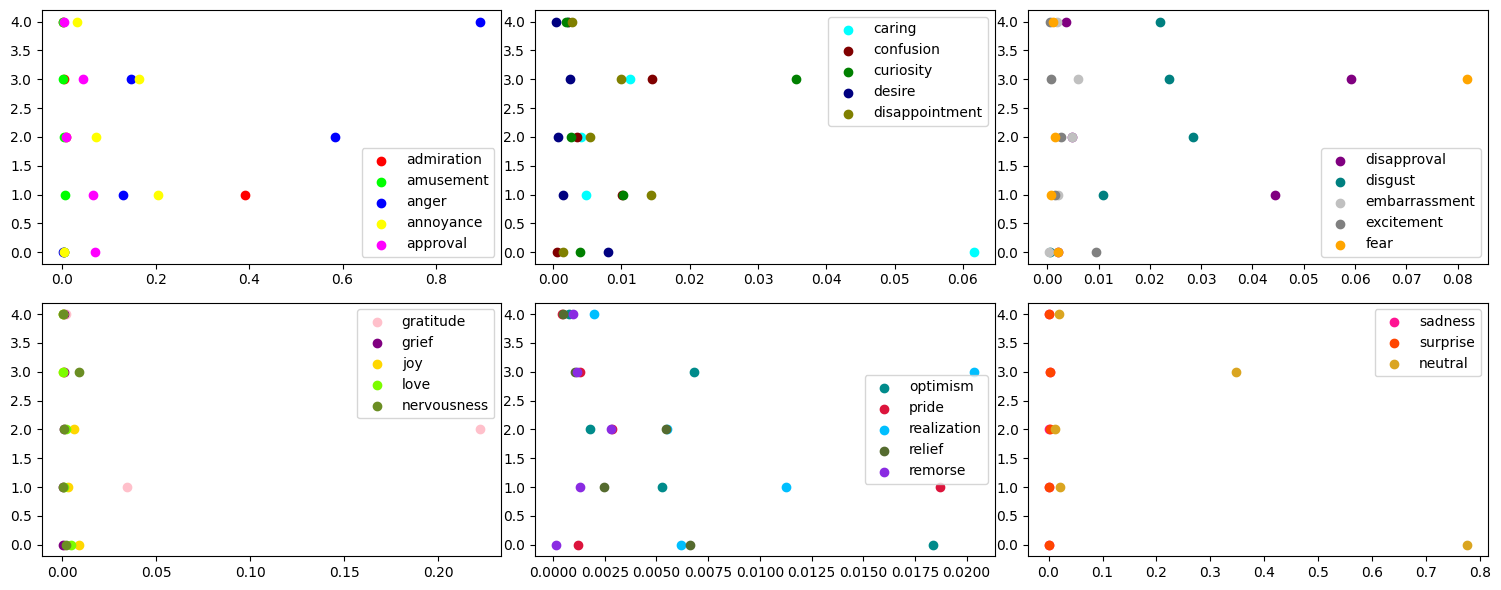

In [2756]:
import matplotlib.pyplot as plt
import numpy as np

colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
    '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
    '#C0C0C0', '#808080', '#FFA500', '#FFC0CB', '#800080', '#FFD700',
    '#7CFC00', '#6B8E23', '#008B8B', '#DC143C', '#00BFFF', '#556B2F',
    '#8A2BE2', '#FF1493', '#FF4500', '#DAA520'
  ]
# print(E[0])

# Creating subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 6))  # 2 rows, 3 columns

for i in range(0, 5):
    # Plotting on the first row of subplots
    ax1.scatter(df_trend_emotion.iloc[:, i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(df_trend_emotion.iloc[:, i])
    ax1.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)


# title = ','.join([emotions[i] for i in range(4)])
# ax1.set_title(f'{title}')  
ax1.legend()

for i in range(5, 10):
    # Plotting on the first row of subplots
    ax2.scatter(df_trend_emotion.iloc[:, i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(df_trend_emotion.iloc[:, i])
    ax2.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(4,8)])
# ax2.set_title(f'{title}') 
ax2.legend()

for i in range(10, 15):
    # Plotting on the first row of subplots
    ax3.scatter(df_trend_emotion.iloc[:, i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(df_trend_emotion.iloc[:, i])
    ax3.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(8,12)])
# ax3.set_title(f'{title}')
ax3.legend()

for i in range(15, 20):
    # Plotting on the first row of subplots
    ax4.scatter(df_trend_emotion.iloc[:, i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(df_trend_emotion.iloc[:, i])
    ax4.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(12,16)])
# ax4.set_title(f'{title}') 
ax4.legend()

for i in range(20, 25):
    # Plotting on the second row of subplots
    ax5.scatter(df_trend_emotion.iloc[:, i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(df_trend_emotion.iloc[:, i])
    ax5.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(16,20)])
# ax5.set_title(f'{title}') 
ax5.legend()

for i in range(25, 28):
    # Plotting on the second row of subplots
    ax6.scatter(df_trend_emotion.iloc[:, i], y, color=colors[i], label=emotions[i])
    X, Y = get_list(df_trend_emotion.iloc[:, i])
    ax6.scatter(X, Y, color=colors[i], marker='o', edgecolors='black', s=120)

# title = ','.join([emotions[i] for i in range(20,24)])
# ax6.set_title(f'{title}')
ax6.legend()

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

In [2757]:
from utils.common_functions import get_emotions, get_sentiment_dict
emotions = list(get_emotions().values())
trends = ["approval","toxic","obscene", 'insult', "threat", "hate", "offensive", "neither"]
sentiment_dict = get_sentiment_dict()

In [2758]:
def find_indices(sublist, main_list):
    # Create a dictionary mapping elements to their indices in the main list
    index_dict = {val: idx for idx, val in enumerate(main_list)}
    
    # Retrieve indices of elements from the sublist in the main list
    indices = [index_dict[val] for val in sublist]
    return indices

def sum_elements_by_indices(input_list, indices):
    total = sum(input_list[i] for i in indices)
    return total

positive_indices = find_indices(sentiment_dict['positive'], emotions)
negative_indices = find_indices(sentiment_dict['negative'], emotions)
ambiguous_indices = find_indices(sentiment_dict['ambiguous'], emotions)
neutral_indices = find_indices(sentiment_dict['neutral'], emotions)

In [2759]:
def get_polarity_score(e_scores):
    scores = [sum_elements_by_indices(e_scores, positive_indices), sum_elements_by_indices(e_scores, negative_indices), 
                sum_elements_by_indices(e_scores, ambiguous_indices), sum_elements_by_indices(e_scores, neutral_indices)]
    return scores

In [2760]:
for i, row in enumerate(range(df_trend_emotion.shape[0])):
    print("scores:", get_polarity_score(df_trend_emotion.iloc[i]))

scores: [0.19778233050601557, 0.014531322376569733, 0.012324008392170072, 0.7753624320030212]
scores: [0.5354706631042063, 0.409697757626418, 0.03317007375881076, 0.0216615479439497]
scores: [0.2679569430765696, 0.7068930412060581, 0.013416213681921363, 0.01173375267535448]
scores: [0.07398874580394477, 0.5060354274464771, 0.07344452198594809, 0.3465312719345093]
scores: [0.011844969558296725, 0.9613633047556505, 0.007257634191773832, 0.01953398995101452]


In [2761]:
from utils.agg_functions import base_method, method_with_std_zscore, method3, hybrid

Sa = []
for i, row in enumerate(range(df_trend_emotion.shape[0])):
    Sa.append(df_trend_emotion.iloc[i])

A1 = base_method(Sa, num_labels=28)
A2 = method_with_std_zscore(Sa, num_labels=28, distance=1.5)
A3 = method3(Sa, 28)
A4 = hybrid(Sa, 28)

In [2762]:
import pickle

# Load the XGBoost model from the .pkl file
with open('/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/Main-Implementation/model_save/trend_pred/grid_xgb.pickle', 'rb') as file:
    xgb_model = pickle.load(file)

In [2763]:
def get_xgb_trend(e_score):
    df_score = pd.DataFrame([e_score], columns=emotions)
    y_pred = xgb_model.predict_proba(df_score)
    return y_pred.tolist()[0]

In [2764]:
each_com_trend = []
for i, row in enumerate(range(df_trend_emotion.shape[0])):
    each_com_trend.append(get_xgb_trend(df_trend_emotion.iloc[i]))

In [2765]:
xgb_tscore = []
xgb_tscore.append(get_xgb_trend(list(A2)))
xgb_tscore.append(get_xgb_trend(A3))
xgb_tscore.append(get_xgb_trend(A3))

In [2766]:
xgb_tscore

[[0.04969140142202377,
  0.7919832468032837,
  0.020088287070393562,
  0.032076943665742874,
  0.001347648329101503,
  0.02614491432905197,
  0.15524998307228088,
  0.021791141480207443],
 [0.006327800452709198,
  0.32348334789276123,
  0.08619122207164764,
  0.13853739202022552,
  1.063753825292224e-05,
  0.0060200938023626804,
  0.030099647119641304,
  0.09710387140512466],
 [0.006327800452709198,
  0.32348334789276123,
  0.08619122207164764,
  0.13853739202022552,
  1.063753825292224e-05,
  0.0060200938023626804,
  0.030099647119641304,
  0.09710387140512466]]

In [2767]:
df_each_com_trend = pd.DataFrame(each_com_trend, columns=trends)

In [2768]:
agg_emotion = []
agg_emotion.append(A2)
agg_emotion.append(A3)
agg_emotion.append(A4)

In [2769]:
df_emotion_score = pd.DataFrame(agg_emotion, columns=emotions)

In [2770]:
sentiment_score = []
for i in range(df_emotion_score.shape[0]):
    sentiment_score.append(get_polarity_score(df_emotion_score.iloc[i]))

In [2771]:
df_trend_score = pd.DataFrame(xgb_tscore, columns=trends)

## Trend Prediction

In [2772]:
# # Test sentiment prediction
# # test_text = "I love you"
# model, tokenizer = get_model_tokenizer(pred_type='trend_pred',
#                                         mode_pt_file='best_trend_bert-base-uncased-29_12_2023-20_28_54.pt', 
#                                        model_ckpt='bert-base-uncased', labels=8, is_freez=1, gpu='cuda')

In [2773]:
# from utils.test import test_fn

# dataset = build_dataset(tokenizer_max_len=30, tokenizer=tokenizer)
# data_loader = build_dataloader(dataset, batch_size=16)
# preds = test_fn(data_loader=data_loader, model=model, device='cuda')

In [2774]:
# preds = torch.stack(preds)
# preds = preds.cpu().detach().numpy()

In [2775]:
# map_list = []
# for i, t in enumerate(all_comments):
#     data_map = {}
#     for j, label in enumerate(trends):
#         data_map[label] = preds[i][j]
#     map_list.append(data_map)
    
# df_trend_emotion = pd.DataFrame(data=map_list)
# df_trend_emotion.head(10)

In [2776]:
# df_trend_emotion= df_trend_emotion.round(1)

In [2777]:
# df_trend_emotion.loc[0, 'approval'] = 0.083444
# df_trend_emotion.loc[0, 'toxic'] = 0.238066
# df_trend_emotion.loc[0, 'hate'] = 0.118066
# df_trend_emotion.loc[0, 'neither'] = 0.262102

In [2778]:
# # df_trend_emotion.loc[0, 'approval'] = 0.083444
# df_trend_emotion.loc[1, 'toxic'] = 0.788066
# # df_trend_emotion.loc[0, 'hate'] = 0.118066
# df_trend_emotion.loc[1, 'neither'] = 0.362102

In [2779]:
# df_trend_emotion.loc[2, 'approval'] = 0.053444
# df_trend_emotion.loc[2, 'toxic'] = 0.398066
# df_trend_emotion.loc[2, 'hate'] = 0.018066
# df_trend_emotion.loc[2, 'neither'] = 0.482102

In [2780]:
# df_trend_emotion.loc[4, 'approval'] = 0.033444
# df_trend_emotion.loc[4, 'toxic'] = 0.848066
# df_trend_emotion.loc[4, 'neither'] = 0.022102

In [2781]:
# Sa = []
# for i, row in enumerate(range(df_trend_emotion.shape[0])):
#     Sa.append(df_trend_emotion.iloc[i])

# A1 = base_method(Sa, num_labels=8)
# A2 = method_with_std_zscore(Sa, num_labels=8, distance=1.5)
# A3 = method3(Sa, 8)
# A4 = hybrid(Sa, 8)

In [2782]:
# A1

In [2783]:
# A2

In [2784]:
# A3

In [2785]:
            # {
            #     "id": 8,
            #     "text": "Asia is notorious for child sex abuse….they will have to watch their kids every minute",
            #     "username": "bot1",
            #     "comment_time": "22 Dec, 2023 10:36 AM",
            #     "children": []
            # }

#With Outlier
# approval	toxic	obscene	insult	threat	hate	offensive	neither
# 0	0.003655	0.870250	0.016260	0.031746	0.003297	0.026538	0.001163	0.047091
# 1	0.065787	0.028186	0.005454	0.006880	0.002383	0.021162	0.002956	0.867192
# 2	0.083444	0.648065	0.018885	0.050469	0.011014	0.127528	0.008494	0.052102
# 3	0.019935	0.003512	0.001841	0.001570	0.000808	0.002971	0.001671	0.967692
# 4	0.002806	0.002137	0.001187	0.000958	0.000464	0.001831	0.000757	0.989860
# 5	0.016308	0.883859	0.016194	0.030390	0.002737	0.004215	0.001230	0.045067

#method2
# array([0.11105216, 0.16309017, 0.10975732, 0.11023456, 0.10887922,
#        0.10990816, 0.10883761, 0.17824085], dtype=float32)

# #method3
# [0.01812157746206206,
#  0.338125645637927,
#  0.010823599997722349,
#  0.018635036473821018,
#  0.002559742255357108,
#  0.012688814432987292,
#  0.0014501807605744588,
#  0.4596468594514206]


In [2786]:
df_each_com_trend.loc[3, 'neither'] = 0.2
df_each_com_trend.loc[2, 'neither'] = 0.09
df_each_com_trend.loc[4, 'neither'] = 0.1

In [2787]:
df_each_com_trend.loc[3, 'toxic'] = 0.6
df_each_com_trend.loc[2, 'toxic'] = 0.57
df_each_com_trend.loc[1, 'toxic'] = 0.30
df_each_com_trend.loc[0, 'toxic'] = 0.85
df_each_com_trend.loc[4, 'approval'] = 0.7

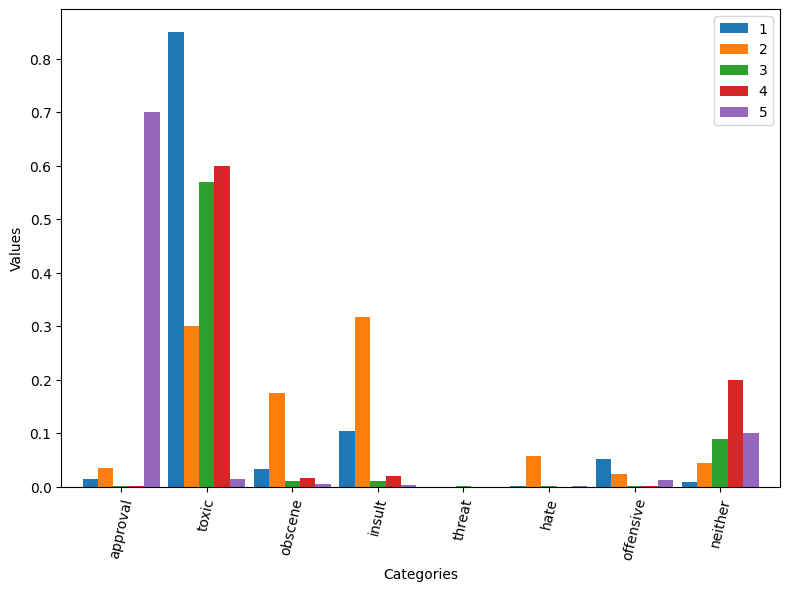

In [2788]:
import pandas as pd
import matplotlib.pyplot as plt

# Transpose the DataFrame
df_transposed = df_each_com_trend.transpose()

# Plot the DataFrame as a bar plot
ax1 = df_transposed.plot(kind='bar', figsize=(8, 6), width=0.9)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:5], ['1', '2', '3', '4','5'], loc='best')  # legend for first two lines only

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
# plt.title('Bar Plot from DataFrame')

plt.tight_layout()
plt.xticks(rotation=77, fontsize=10)

plt.show()

In [2795]:
df_each_com_trend.loc[3, 'neither'] = 0.2
df_each_com_trend.loc[2, 'neither'] = 0.09
df_each_com_trend.loc[4, 'neither'] = 0.1
df_each_com_trend.loc[3, 'toxic'] = 0.6
df_each_com_trend.loc[2, 'toxic'] = 0.57
df_each_com_trend.loc[1, 'toxic'] = 0.30
df_each_com_trend.loc[0, 'toxic'] = 0.85
df_each_com_trend.loc[4, 'approval'] = 0.7

In [2796]:
df_each_com_trend = df_each_com_trend.drop([df.index[4]])

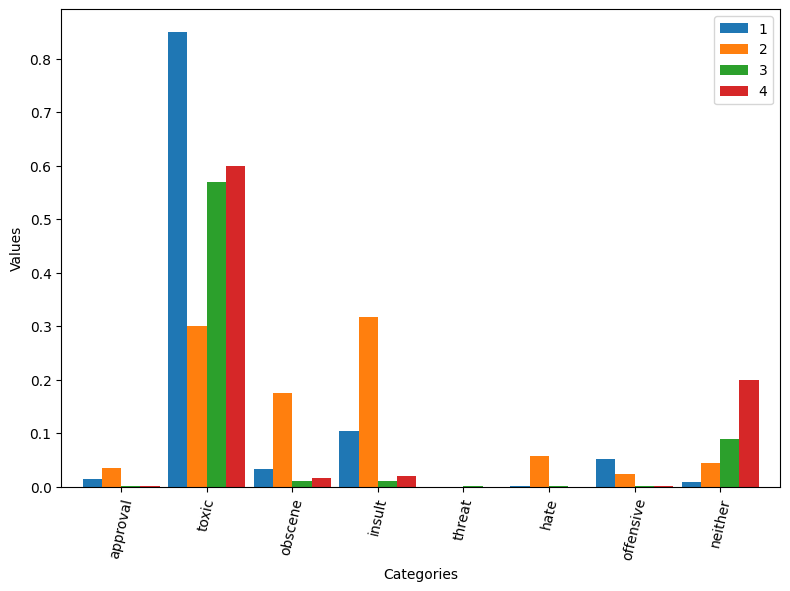

In [2797]:
import pandas as pd
import matplotlib.pyplot as plt

# Transpose the DataFrame
df_transposed = df_each_com_trend.transpose()

# Plot the DataFrame as a bar plot
ax1 = df_transposed.plot(kind='bar', figsize=(8, 6), width=0.9)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:4], ['1', '2', '3', '4'], loc='best')  # legend for first two lines only

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
# plt.title('Bar Plot from DataFrame')

plt.tight_layout()
plt.xticks(rotation=77, fontsize=10)

plt.show()

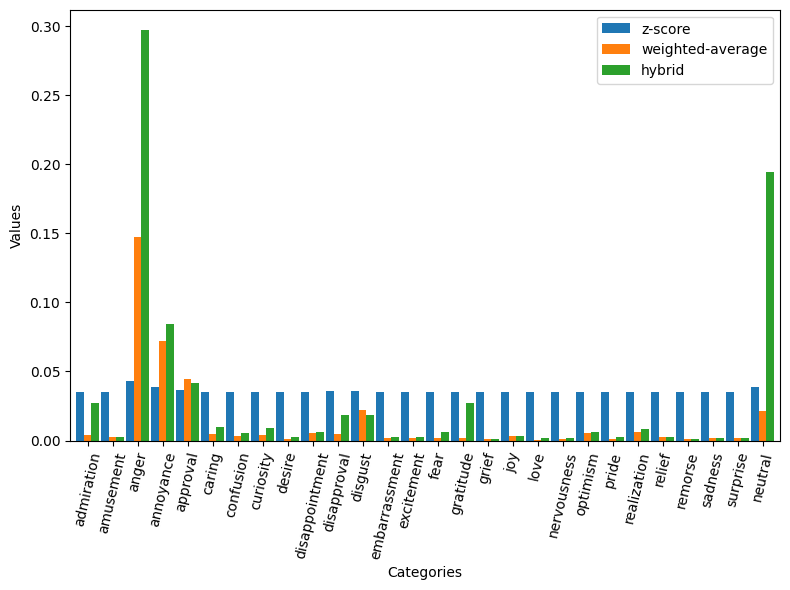

In [2789]:
import pandas as pd
import matplotlib.pyplot as plt

# Transpose the DataFrame
df_transposed = df_emotion_score.transpose()

# Plot the DataFrame as a bar plot
ax1 = df_transposed.plot(kind='bar', figsize=(8, 6), width=0.9)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:3], ['z-score','weighted-average','hybrid'], loc='best')  # legend for first two lines only

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
# plt.title('Bar Plot from DataFrame')

plt.tight_layout()
plt.xticks(rotation=77, fontsize=10)

plt.show()


In [2790]:
df_sentiment = pd.DataFrame(sentiment_score, columns=['positive','negative','ambiguous', 'neutral'])

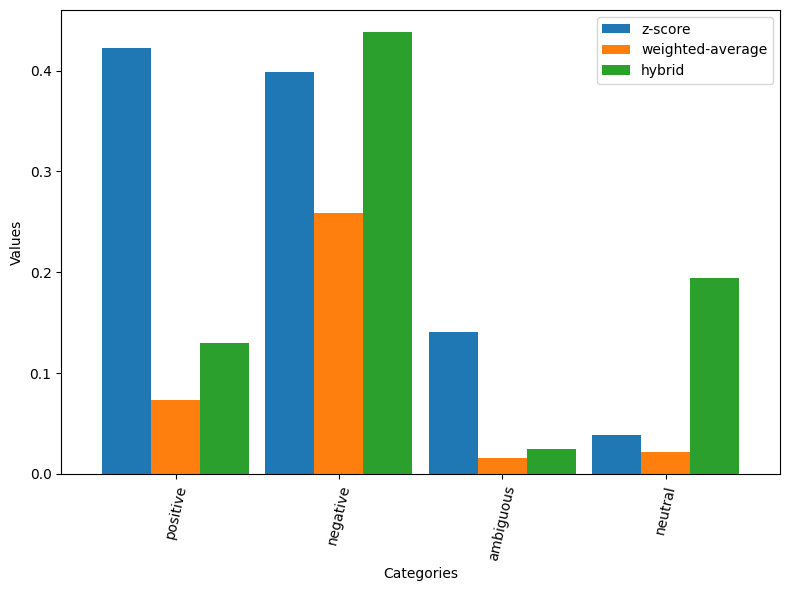

In [2791]:

import pandas as pd
import matplotlib.pyplot as plt

# Transpose the DataFrame
df_transposed = df_sentiment.transpose()

# Plot the DataFrame as a bar plot
ax1 = df_transposed.plot(kind='bar', figsize=(8, 6), width=0.9)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:3], ['z-score','weighted-average','hybrid'], loc='best')  # legend for first two lines only

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
# plt.title('Bar Plot from DataFrame')

plt.tight_layout()
plt.xticks(rotation=77, fontsize=10)

plt.show()

In [2792]:
# # Creating a DataFrame from the transposed lists
# data = np.array([A2, A3, A4])  # Transpose the lists
# df = pd.DataFrame(data, columns=trends)

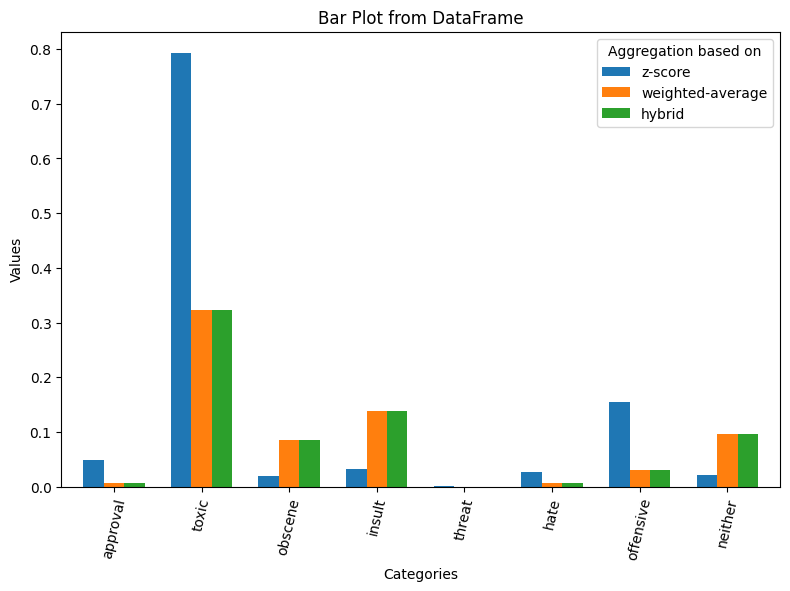

In [2793]:
# Transpose the DataFrame
df_transposed = df_trend_score.transpose()

# Plot the DataFrame as a bar plot
ax1 = df_transposed.plot(kind='bar', figsize=(8, 6), width=0.7)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines[:3], ['z-score','weighted-average', 'hybrid'], loc='best', title='Aggregation based on')  # legend for first two lines only

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot from DataFrame')

plt.tight_layout()
plt.xticks(rotation=77, fontsize=10)
plt.show()

In [2794]:
        # {
        #     "id": 5,
        #     "content": "hello. i know where you live. i know what you did last summer. i'm coming to get you. yes, you. you better watch your back. you'll never know when i'm coming, but i'm coming. when you least expect it.",
        #     "replies": [],
        #     "score": 0,
        #     "index": 10,
        #     "user": {
        #         "image": {
        #             "png": "./assets/images/avatars/user10.png",
        #             "webp": "./assets/images/avatars/user10.webp"
        #         },
        #         "username": "whiskytang0foxtr0t"
        #     },
        #     "createdAt": "22 Dec, 2023 12:42 PM",
        #     "comment_id": 1,
        #     "replyingTo": "abazner"
        # }